# Evaluation of Graph Neural Network segment classifier

In [1]:
%pwd

'/global/u2/s/sfarrell/WorkAreas/trackml/heptrkx-gnn-tracking/notebooks'

In [2]:
# System imports
import os
import sys
import pprint

# External imports
import matplotlib.pyplot as plt
import numpy as np

# Limit CPU usage on Jupyter
os.environ['OMP_NUM_THREADS'] = '4'

# Pick up local packages
sys.path.append('..')

# Local imports
from trainers import get_trainer
from nb_utils import (load_config_file, load_config_dir, load_summaries,
                      plot_train_history, get_test_data_loader,
                      compute_metrics, plot_metrics, draw_sample_xy)

In [3]:
%matplotlib inline

## Load training results

Specify which results to load either by config file or training output directory.

In [4]:
# Load by directory (preferred)
result_base = os.path.expandvars('$SCRATCH/heptrkx/results')

In [5]:
ls $result_base

RNNFilter_20180207_1121/  gnnsegclf_big_002/    mpnn_002/      resepnn_big_001/
agnn_000/                 gnnsegclf_big_003/    mpnn_batch/    resepnn_big_003/
agnn_001/                 gnnsegclf_med_000/    mpnn_big_000/  resmpnn_001/
agnn_002/                 gnnsegclf_med_009/    mpnn_big_001/  resmpnn_002/
agnn_002_8gpu/            gnnsegclf_med_010/    mpnn_big_002/  resmpnn_002a/
agnn_big_000/             gnnsegclf_med_011/    mpnn_big_003/  resmpnn_big_000/
agnn_big_001/             gnnsegclf_small_000/  mpnn_big_004/  resmpnn_big_001/
agnn_big_002/             gnnsegclf_small_001/  mpnn_big_005/  resmpnn_big_002/
agnn_scaling/             gnnsegclf_small_002/  mpnn_big_006/  resmpnn_big_003/
gnnsegclf_000/            gnnsparse_big_001/    mpnn_big_007/  stable_big_001/
gnnsegclf_001/            gnnsparse_med_001/    mpnn_big_008/  temp/
gnnsegclf_004/            hello/                mpnn_med_000/  test_000/
gnnsegclf_big_000/        mpnn_001/             mpnn_med_001/


In [6]:
result_name = 'agnn_002'
result_dir = os.path.join(result_base, result_name)

config = load_config_dir(result_dir)
print('Configuration:')
pprint.pprint(config)

summaries = load_summaries(config)
print('\nTraining summaries:')
summaries

Configuration:
{'data': {'batch_size': 4,
          'input_dir': '${SCRATCH}/heptrkx/data/hitgraphs_high_000',
          'n_train': 49152,
          'n_valid': 4096,
          'n_workers': 4,
          'name': 'hitgraphs_sparse',
          'real_weight': 5},
 'model': {'hidden_dim': 64,
           'input_dim': 3,
           'layer_norm': True,
           'loss_func': 'binary_cross_entropy_with_logits',
           'n_graph_iters': 8,
           'name': 'agnn'},
 'optimizer': {'learning_rate': 0.01,
               'lr_decay_schedule': [{'end_epoch': 32,
                                      'factor': 0.1,
                                      'start_epoch': 16},
                                     {'end_epoch': 64,
                                      'factor': 0.01,
                                      'start_epoch': 32}],
               'lr_scaling': 'sqrt',
               'lr_warmup_epochs': 5,
               'momentum': 0.9,
               'name': 'SGD'},
 'output_dir': '/global/c

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
0,0.0100,0.303687,0,1474.417899,0.425829,0.787377,57.164771
1,0.0100,0.150562,1,1476.598240,0.125673,0.951785,57.562468
2,0.0100,0.110914,2,1477.034329,0.099926,0.964887,57.305213
3,0.0100,0.093118,3,1474.792798,0.085782,0.970028,57.326536
4,0.0100,0.084624,4,1477.945691,0.083229,0.971209,57.301522
5,0.0100,0.078549,5,1476.466057,0.079119,0.973148,57.017896
6,0.0100,0.074148,6,1484.191794,0.060107,0.980393,58.167580
7,0.0100,0.070999,7,1520.010619,0.059168,0.980806,58.492109
8,0.0100,0.068452,8,1561.259191,0.055599,0.982219,62.432609
9,0.0100,0.066743,9,1579.605147,0.055412,0.982132,63.444378


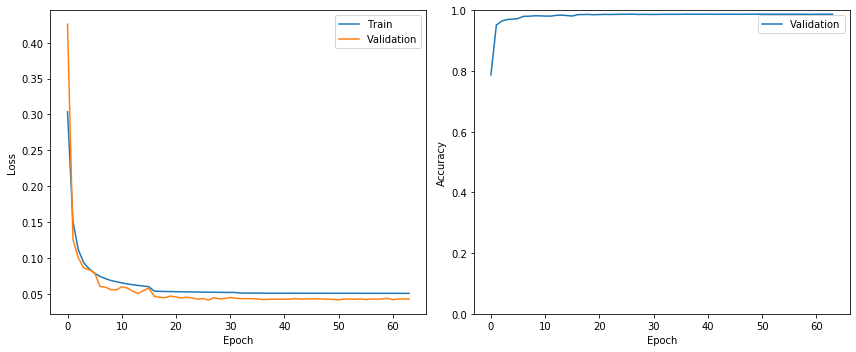

In [7]:
plot_train_history(summaries)

Text(0, 0.5, 'Learning rate')

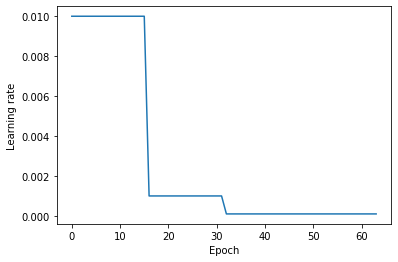

In [8]:
# Plot the learning rate
plt.figure()
plt.plot(summaries.lr)
plt.xlabel('Epoch')
plt.ylabel('Learning rate')

## Load the trained model

In [9]:
# Find the best epoch
best_idx = summaries.valid_loss.idxmin()
summaries.loc[[best_idx]]

,lr,train_loss,epoch,train_time,valid_loss,valid_acc,valid_time
26,0.001,0.052105,26,1532.037693,0.04122,0.987825,65.120786


In [10]:
# Build the trainer and load best checkpoint
trainer = get_trainer(output_dir=config['output_dir'], **config['trainer'])
trainer.build_model(optimizer_config=config['optimizer'], **config['model'])

best_epoch = summaries.epoch.loc[best_idx]
trainer.load_checkpoint(checkpoint_id=best_epoch)

print(trainer.model)
print('Parameters:', sum(p.numel() for p in trainer.model.parameters()))

GNNSegmentClassifier(
  (input_network): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2): Tanh()
  )
  (edge_network): EdgeNetwork(
    (network): Sequential(
      (0): Linear(in_features=134, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_features=64, bias=True)
      (4): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (5): Tanh()
      (6): Linear(in_features=64, out_features=64, bias=True)
      (7): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (8): Tanh()
      (9): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (node_network): NodeNetwork(
    (network): Sequential(
      (0): Linear(in_features=201, out_features=64, bias=True)
      (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      (2): Tanh()
      (3): Linear(in_features=64, out_fea

## Evaluate the model on the test dataset

In [11]:
# Load the test dataset
n_test = 64
test_loader = get_test_data_loader(config, n_test=n_test)

In [12]:
%%time
# Apply the model
test_preds, test_targets = trainer.predict(test_loader)

CPU times: user 1min 5s, sys: 2.75 s, total: 1min 8s
Wall time: 17.2 s


In [13]:
threshold = 0.5
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.5
Accuracy:  0.9880
Precision: 0.8818
Recall:    0.9628


In [14]:
threshold = 0.8
test_metrics = compute_metrics(test_preds, test_targets, threshold=threshold)

print('Test set results with threshold of', threshold)
print('Accuracy:  %.4f' % test_metrics.accuracy)
print('Precision: %.4f' % test_metrics.precision)
print('Recall:    %.4f' % test_metrics.recall)

Test set results with threshold of 0.8
Accuracy:  0.9923
Precision: 0.9533
Recall:    0.9397


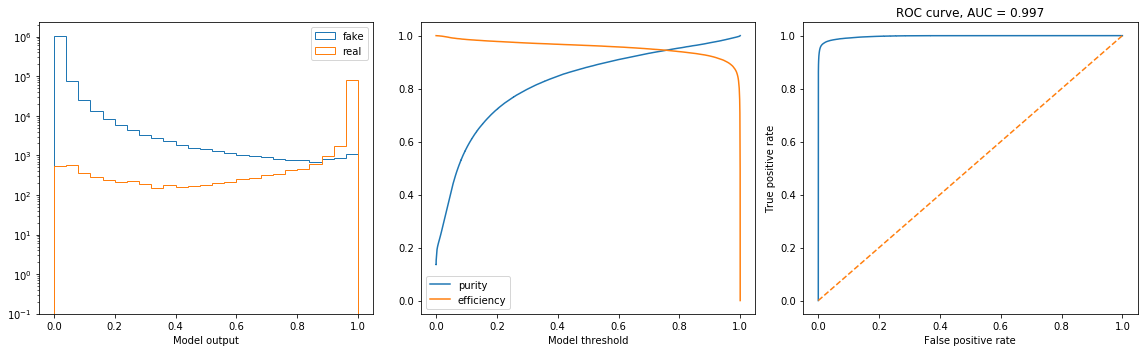

In [15]:
plot_metrics(test_preds, test_targets, test_metrics)

## Visualize predictions

In [16]:
n_phi_sections = 8
feature_scale = np.array([1000., np.pi / n_phi_sections, 1000.])

In [17]:
i = 0

g = test_loader.dataset[i]
e = g.edge_index.numpy()
x = g.x.numpy() * feature_scale
y = g.y.numpy()
o = test_preds[i].numpy()

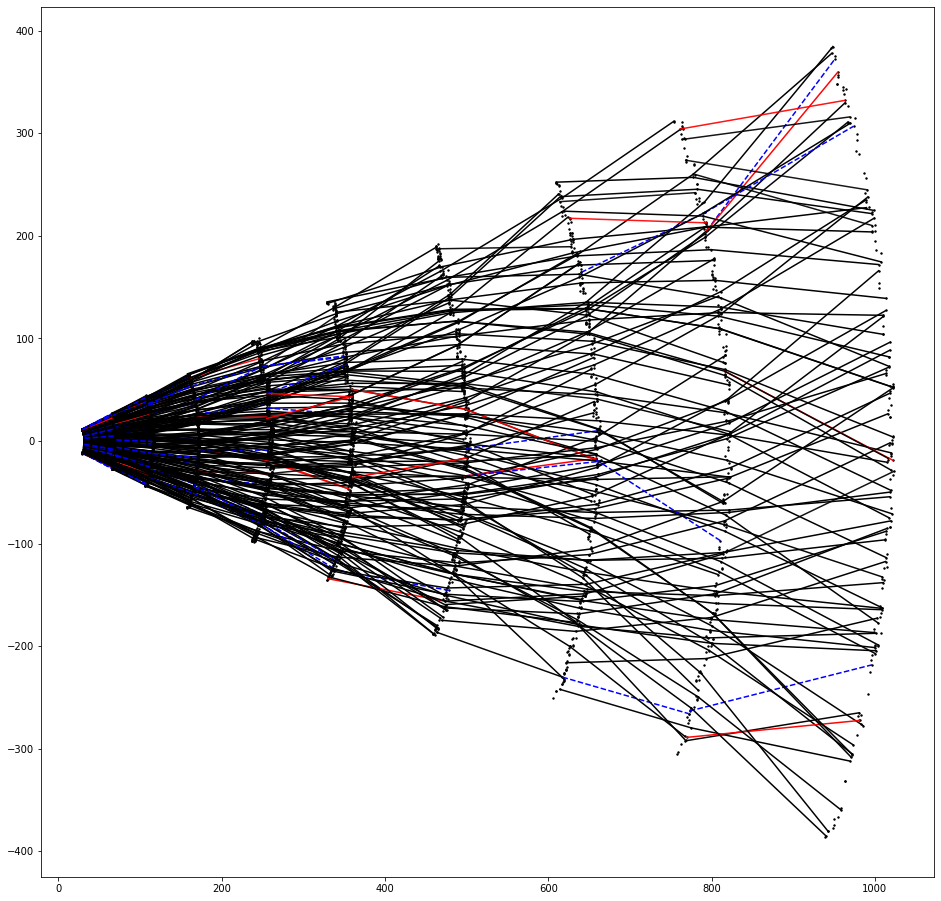

In [18]:
draw_sample_xy(x, e, o, y, cut=0.9);